Import necessary libraries

In [143]:
import pandas as pd
import numpy as np
from lxml import html
import requests
import nltk
#import stopwords from natural language toolkit
from nltk.corpus import stopwords
#nltk.download("stopwords")
from itertools import groupby
import os
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [2]:
#create an empty dataframe
df=pd.DataFrame()

In [3]:
#stop words
stops = set(stopwords.words('english'))
stops

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [4]:
def freq_counter(word_list):
    wdict={}
    for w in word_list:
        if w in wdict:
           wdict[w]=wdict[w]+1
        else:
            wdict[w]=1
    #retun a dictionary with frequency count for each word
    return wdict

The following function will first load the web page, scrape contents, remove white spaces, put individual words into a list, check against stopwords list, remove stopwords, special chars and numbers. Finally it will count each word and return a dictionary of frequency key-value pairs.

In [11]:
def get_term_freq_from_url(url,label,df):
    str_=''
    #load the webpage
    #page = requests.get(url)
    #xpath, parse through html
    #tree = html.fromstring(page.content)
    #p = tree.xpath('//p/text()')
    #combine list items into a string
    
    os.environ['MOZ_HEADLESS'] = '1'
    driver = webdriver.Firefox()
    #driver.implicitly_wait(30)
    try:
        driver.get(url)    
        #wait = WebDriverWait(driver, 1)
        #wait.until(EC.visibility_of_element_located((By.TAG_NAME, "div")))

        driver.find_element_by_css_selector('.btn').click()

        html = driver.page_source
        soup = BeautifulSoup(html)
        content = soup.find_all('div', {'data-rapid-subsec' : 'paragraph'})
    except:
        print('Error')
        content=''
    driver.quit()
    for c in content:
        str_ = str_ + c.text
    #p=" ".join(str)
    punc=['!','.',',','(',')','?','{','}','[',']','\\','/','*','@','#','$','&','~','"',':','_']
    #split words by spaces and converted them into a list
    p=str_.split(" ")
    wlist=[]
    for word in p:
        if word.lower().strip() not in stops:
            #leave out numbers, check if the characters are alphabets
            for p in punc:
                    word=word.replace(p,"")
            #if alphabet, put it into wlist; if digit, skip
            if word.strip().isalpha()==True:
                if word.strip() != "":
                    wlist.append(word)
    #get term frequency as a dictionary
    #tf_dict = {value: len(list(freq)) for value, freq in groupby(sorted(wlist))}
    tf_dict=freq_counter(wlist)
    tf_dict['label']=label
    df2  = pd.DataFrame([tf_dict], columns=tf_dict.keys())
    df = pd.concat([df, df2], axis =0)
    return df

In [181]:
def get_term_freq_from_string(string,label,df):

    punc=['!','.',',','(',')','?','{','}','[',']','\\','/','*','@','#','$','&','~','"',':','_']
    #split words by spaces and converted them into a list
    p=string.split(" ")
    wlist=[]
    for word in p:
        if word.lower().strip() not in stops:
            #leave out numbers, check if the characters are alphabets
            for p in punc:
                    word=word.replace(p,"")
            #if alphabet, put it into wlist; if digit, skip
            if word.strip().isalpha()==True:
                if word.strip() != "":
                    wlist.append(word)
    #get term frequency as a dictionary
    #tf_dict = {value: len(list(freq)) for value, freq in groupby(sorted(wlist))}
    tf_dict=freq_counter(wlist)
    tf_dict['label']=label
    df2  = pd.DataFrame([tf_dict], columns=tf_dict.keys())
    df = pd.concat([df, df2], axis =0)
    return df

Here I will pass a list of URLs with label for each story.

It is tedious to do it manually. So I am using a data set created by Rishabh Misra. It contains over 200,000 articles from Huffington post with category label, headline, author names, link, short description and date. You can download the dataset at https://www.kaggle.com/rmisra/news-category-dataset

In [6]:
import json
articles=pd.read_json("News_Category_Dataset_v2.json",lines=True)
articles

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
...,...,...,...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28


There are over 200,000 articles in this data set. The whole set can be used to train the model but it will take a very long time on my laptop. So I will make a smaller subset by selecting random rows.

In [42]:
#shuffling the rows
articles = articles.sample(frac=1).reset_index(drop=True)
articles

,category,headline,authors,link,short_description,date
0,IMPACT,The Countdown Starts Now,"Sarah Brown, ContributorPresident of Theirworl...",https://www.huffingtonpost.com/entry/the-count...,Despite significant progress allowing tens of ...,2014-08-18
1,HEALTHY LIVING,On Retreat,"Mark Nepo, ContributorAuthor, New York Times b...",https://www.huffingtonpost.com/entry/on-retrea...,It's humbling how fear can rearrange our eyes....,2014-12-02
2,WELLNESS,The Alphabet of Happiness: 'G',"Randy Taran, Contributor\nFounder of projectha...",https://www.huffingtonpost.com/entry/the-alpha...,"Today let's look at Giving, Grace, and sharing...",2013-06-06
3,POLITICS,California Ballot Measure Fails To Create Many...,"JULIA HOROWITZ, AP",https://www.huffingtonpost.com/entry/californi...,"Only 1,700 jobs have been created in three years.",2015-08-17
4,ARTS & CULTURE,Most Notable Quote Of 2016? Trump Saying He Co...,Claire Fallon,https://www.huffingtonpost.com/entry/trump-quo...,That about sums up this year.,2016-12-16
...,...,...,...,...,...,...
200848,EDUCATION,Education Policies Worthy of the Name 'Reform',"Randi Weingarten, ContributorPresident, Americ...",https://www.huffingtonpost.com/entry/education...,This new law can create positive change. State...,2015-12-20
200849,TRAVEL,"Smart Travel Advice: The More You Travel, the ...","Christopher Elliott, Contributor\nAuthor, How ...",https://www.huffingtonpost.com/entry/smart-tra...,"""The world is essentially a friendly place and...",2014-02-21
200850,SPORTS,Washington's NFL Team Is In Desperate Need Of ...,Kim Bellware,https://www.huffingtonpost.com/entry/washingto...,The owner who chose the team's controversial n...,2016-04-28
200851,POLITICS,The Democrats' 'Working-Class Problem',"The American Prospect, ContributorLiberal Inte...",https://www.huffingtonpost.com/entry/the-democ...,The Democrats also missed the economic stress ...,2017-06-02


In [97]:
#selecting first 500 articles from the list
articles2=articles[:500]
articles2.shape

(500, 6)

In [109]:
df=pd.DataFrame()
#breaking up 3000 into 6 different loops. For some reason, it is faster than running 3000 at once.
#for x in range(1,6):
#    articles2=articles[500*(x-1):500*x]
for index, row in articles2.iterrows():
    #print(row['category'], row['link'])
    df=get_term_freq_from_string(row['headline']+" "+row['short_description'],row['category'],df)
    df=df.fillna(0).reset_index(drop=True)
df

,Bryner,Care,Health,Hill,Lobbyists,Sarah,Strangers,aides,approving,care,...,Four,Haiku,Recap,none,Creating,Kiss,Perfection,kiss,lifetime,seal
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
articles2=articles[501:1000]
for index, row in articles2.iterrows():
    #print(row['category'], row['link'])
    df=get_term_freq_from_string(row['headline']+" "+row['short_description'],row['category'],df)
    df=df.fillna(0).reset_index(drop=True)
df

,Bryner,Care,Health,Hill,Lobbyists,Sarah,Strangers,aides,approving,care,...,Amid,Lecture,conservative,lecture,pundit,vowed,Means,deductions,papers,refund
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [115]:
df3 = df.copy()
df3.drop(['label'],axis=1,inplace=True)
df3 = df3.replace(0, np.nan)
df3 = df3.dropna(how='all', axis=0)
df3 = df3.replace(np.nan, 0)
df3['label']=df['label']
df3=df3.reset_index(drop=True)
df3

,Bryner,Care,Health,Hill,Lobbyists,Sarah,Strangers,aides,approving,care,...,Colombian,Fully,Legalizing,Toward,illegal,incest,Classic,Solo,predict,label
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POLITICS
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HOME & LIVING
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PARENTS
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TECH
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PARENTING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POLITICS
1342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEDIA
1343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,LATINO VOICES
1344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,ENTERTAINMENT


In [116]:
bbc=pd.read_csv("Downloads/bbc.csv")
bbc_500=bbc[:500]
for index, row in bbc_500.iterrows():
    #print(row['category'], row['link'])
    df=get_term_freq_from_string(row['news'],row['type'],df)
    df=df.fillna(0).reset_index(drop=True)
df

,Bryner,Care,Health,Hill,Lobbyists,Sarah,Strangers,aides,approving,care,...,disputed,industrially,proxy,swallowed,clamour,horns,nudging,opts,reinforcing,upside\n
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


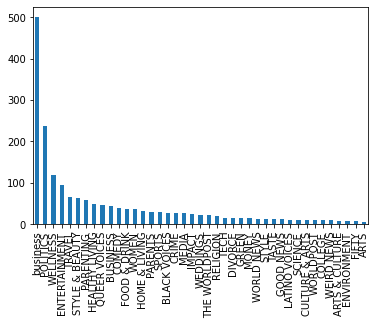

In [119]:
df['label'].value_counts().plot(kind='bar')

In [120]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(["paris", "paris", "tokyo", "amsterdam"])
test=le.transform(["amsterdam", "tokyo", "paris"])
y = df['label'].values
y[0:5]

array(['POLITICS', 'HOME & LIVING', 'PARENTS', 'TECH', 'PARENTING'],
      dtype=object)

In [137]:
df_nolabel=df.loc[:, df.columns != 'label']
X = df_nolabel.values
X[0:5]

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [138]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1476, 18754) (1476,)
Test set: (370, 18754) (370,)


In [144]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc


print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.15989159891598917
Test set Accuracy:  0.06486486486486487


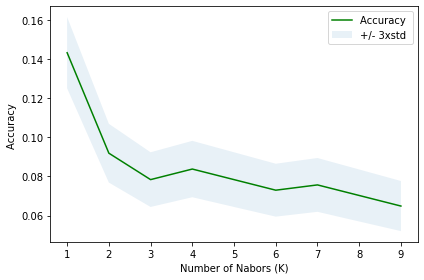

In [145]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

In [146]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.14324324324324325 with k= 1


In [147]:
yhat = neigh.predict(X_test)
yhat[0:5]

array(['ENTERTAINMENT', 'ENTERTAINMENT', 'ENTERTAINMENT',
       'STYLE & BEAUTY', 'ENTERTAINMENT'], dtype=object)

In [229]:
print(str(round((df.memory_usage(index=True).sum())/(1024*1024)))+" Megabtyes")

264.0 Megabtyes


In [226]:
df_10=df.copy()
df_10

,Bryner,Care,Health,Hill,Lobbyists,Sarah,Strangers,aides,approving,care,...,disputed,industrially,proxy,swallowed,clamour,horns,nudging,opts,reinforcing,upside\n
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [230]:
# for TF-IDF, we have TF for each word as seen in the dataframe. We need IDF which is log(D/Dfi).
# D=number of docs. Dfi= number of docs containg the term. Using log to hammer out large numbers.
# adding +1 to both numerator and denominator to avoid division by zero error
num_docs=df_10.shape[0]
num_cols=df_10.shape[1]
import math

idf=math.log((num_docs+1)/(dfi+1))

for ind,col in enumerate(df_10):
    dfi=0
    if col == 'label':
        continue
    for i, row_value in df_10[col].iteritems():
        if row_value > 0:
            dfi=dfi+1
    for i, row_value in df_10[col].iteritems():
        idf=math.log((num_docs+1)/(dfi+1))
        df_10.iat[i,ind]=row_value*idf

There are over 34 million cells in DF. 1846 rows x 18755 columns

In [231]:
df_10

,Bryner,Care,Health,Hill,Lobbyists,Sarah,Strangers,aides,approving,care,...,disputed,industrially,proxy,swallowed,clamour,horns,nudging,opts,reinforcing,upside\n
0,46.623916,27.235173,18.863943,37.638515,46.623916,37.638515,46.623916,41.251148,46.623916,20.480926,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,0.000000,0.000000,18.863943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1842,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1844,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.828171,6.828171,6.828171,6.828171,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [232]:
y2 = df_10['label'].values
y2[0:5]
df_nolabel=df_10.loc[:, df_10.columns != 'label']
X2 = df_nolabel.values
X2[0:5]

from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split( X2, y2, test_size=0.2, random_state=4)
print ('Train set:', X_train2.shape,  y_train2.shape)
print ('Test set:', X_test2.shape,  y_test2.shape)

Train set: (1476, 18754) (1476,)
Test set: (370, 18754) (370,)


In [241]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train2,y_train2)
    yhat=neigh.predict(X_test2)
    mean_acc[n-1] = metrics.accuracy_score(y_test2, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test2)/np.sqrt(yhat.shape[0])

mean_acc


print("Train set Accuracy: ", metrics.accuracy_score(y_train2, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test2, yhat))

Train set Accuracy:  0.05555555555555555
Test set Accuracy:  0.05945945945945946


In [249]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10000, random_state=0)
classifier.fit(X_train2, y_train2) 

KeyboardInterrupt: 

In [ ]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#print(confusion_matrix(y_test2,y_pred))
#print(classification_report(y_test2,y_pred))
print(accuracy_score(y_test2, y_pred))

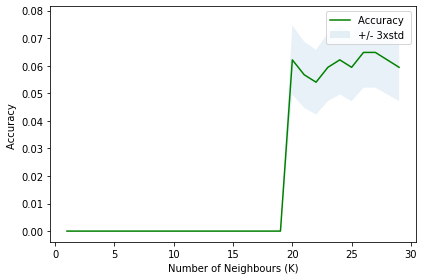

In [242]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

In [243]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.06486486486486487 with k= 26


In [244]:
yhat = neigh.predict(X_test2)
yhat[0:5]

array(['ENTERTAINMENT', 'ENTERTAINMENT', 'COMEDY', 'STYLE & BEAUTY',
       'ENTERTAINMENT'], dtype=object)